In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 14.0 Background

### Classification Models

[pre-trained models](https://www.tensorflow.org/api_docs/python/tf/keras/applications)




## 14.0.1 Transfer Learning

* 실제 문제를 해결하는 복잡한 모델을 학습하는데 필요한 데이터를 구하기가 어려움 (데이터부족)
* 수백만장의 데이터로 신경망을 학습시키기 위해서는 엄청난 양의 계산 자원이 필요함 (고비용)
* 온라인에 공개된 모델을 이용하여 우리가 해결할 문제에 적용함
* 상대적으로 작은 데이터셋과 짧은 학습 시간으로 더 높은 성능을 거둘 수 있음

### VGG16 모델을 이용한 Transfer Learning

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16

image_size=64
image_shape=(image_size,image_size,3)
input_layer=tf.keras.layers.Input(shape=image_shape)
model_vgg16=VGG16(weights='imagenet', input_tensor=input_layer, include_top=False)
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
for layer in model_vgg16.layers[:-1]:
    layer.trainable=False
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [ ]:
features_output=model_vgg16.output
#flatten=tf.keras.layers.Flatten()(features_output)
#dense1=tf.keras.layers.Dense(128,activation='relu')(flatten)
#dense2=tf.keras.layers.Dense(64,activation='relu')(dense1)
pool = tf.keras.layers.GlobalAveragePooling2D()(features_output)
output_layer=tf.keras.layers.Dense(10,activation='softmax')(pool)
model=tf.keras.models.Model(inputs=input_layer,outputs=output_layer)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0   

(64, 64, 3)


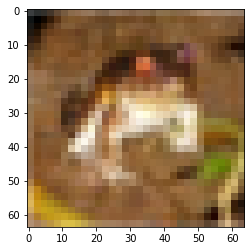

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input size for cifar10 is 32 x 32 x 3
# input size for VGG16 model is 224 x 224 x 3

def normalize(input_image, y_train):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  return input_image, y_train

def resize_image(input_image, y_train):
  input_image = tf.image.resize(input_image, [image_size, image_size],\
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )
  return input_image, y_train

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)\
                                .map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

for image, label in train_dataset.take(1):
  print(image.shape)
  #print(image)
  plt.figure()
  plt.imshow(image)

train_dataset = train_dataset.cache().shuffle(60000).batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test) )
test_dataset = test_dataset.map(resize_image, num_parallel_calls=tf.data.AUTOTUNE)\
                                .map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().batch(64).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
history=model.fit(train_dataset, validation_data=test_dataset, epochs=1)

In [ ]:
f, ax = plt.subplots()
ax.plot(history.history['accuracy'], 'o-')
ax.plot(history.history['val_accuracy'], 'x-')

ax.legend(['Train acc', 'Validation acc'], loc = 0)
ax.set_title('Training/Validation acc per Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('acc')

plt.show()

# 14.1 Image Classification (ResNet50 Transfer Learning)

* 파라미터 개수: 2560 만개

[ImageNet Benchmark](https://paperswithcode.com/sota/image-classification-on-imagenet)

## Lab 008

> 문제 15 - ResNet50 모델을 이용한 Transfer Learning
---

ResNet50 모델을 이용하여 cifar10 이미지 분류 모델을 생성하시오. 

단, tensorflow에서 제공하는 ResNet50 모델을 이용하시오.

Hint: 14.0.4 를 참고하시오.

# 과제 003

---

MobileNetV2 모델을 이용하여 cifar10 이미지 분류 모델을 생성하시오. 

단, tensorflow에서 제공하는 MobileNetV2 모델을 이용하시오.

### 제출

구현한 코드가 담긴 colab 파일을 PLATO "텐서플로 과제 제출"에 제출하세요. (1/13까지)

Hint: [Tutorial](https://www.tensorflow.org/tutorials/images/transfer_learning)

# 14.2 Image Segmentation (U-Net Transfer Learning)

픽셀 단위로 이미지에 존재하는 객체를 추출하는 방법

* 시맨틱 분할: 클래스가 같은 객체는 같은 그룹으로 묶어서 분할
* 인스턴스 분할: 클래스가 같더라도 각각의 객체를 분리해서 분할하는 방법


<img src="https://miro.medium.com/max/1400/0*QeOs5RvXlkbDkLOy.webp" width=800 />


### 활용분야

* 제조 공정에서 제품을 이미지로 감지하여 불량 위치를 형태로 발견함
* 조립할 때 로봇 팔이 작업 위치를 정확히 찾아야 할 때
* 자율 주행 알고리즘에서 보행자나 주변 차량, 차선, 교통 표지판 등의 윤곽을 정확히 추출해야 함
* 항공사진이나 위성사진에서 건물, 도로, 하천, 논 등을 분리해 국토 개발 현황이나 환경 변화를 분석하는데 활용

[딥러닝 개념과 활용, 김의중](http://www.yes24.com/Product/Goods/100527200)





## 14.2.1 Images, Masks, and Labels

<img src="
https://assets-global.website-files.com/5d7b77b063a9066d83e1209c/616b648b00d9595e571bd77b_an-overview-of-semantic-image-segmentation%20(1).png" width=800 />


output (1, 10, 10, 3)
loss () tf.Tensor(1.3027513, shape=(), dtype=float32)
y_train (1, 10) [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]
output (1, 10)
loss () tf.Tensor(3.0374074, shape=(), dtype=float32)


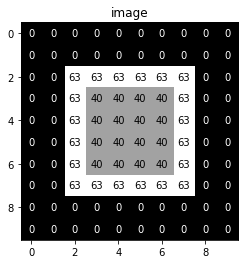

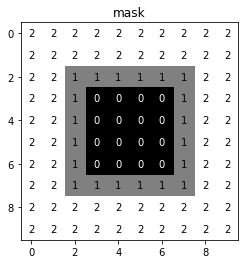

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def visualize_image(img, title):
    plt.figure()
    plt.title(title)
    plt.imshow(img, cmap='gray')
    width, height = img.shape
    #print(img)
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            plt.annotate(str(img[x][y]), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')
              
# x_train - 하나의 이미지 10 x 10
image = np.array([[0,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,0],
         [0,0,63,63,63,63,63,63,0,0],
         [0,0,63,40,40,40,40,63,0,0],
         [0,0,63,40,40,40,40,63,0,0],
         [0,0,63,40,40,40,40,63,0,0],
         [0,0,63,40,40,40,40,63,0,0],
         [0,0,63,63,63,63,63,63,0,0],
         [0,0,0,0,0,0,0,0,0,0],
         [0,0,0,0,0,0,0,0,0,0]])
#plt.figure()
#plt.imshow(image)
visualize_image(image, 'image')
output = tf.random.normal(shape=(1, 10, 10, 3))
print('output', output.shape)

# y_train - 하나의 이미지 10 x 10
mask   = np.array([[2,2,2,2,2,2,2,2,2,2],
         [2,2,2,2,2,2,2,2,2,2],
         [2,2,1,1,1,1,1,1,2,2],
         [2,2,1,0,0,0,0,1,2,2],
         [2,2,1,0,0,0,0,1,2,2],
         [2,2,1,0,0,0,0,1,2,2],
         [2,2,1,0,0,0,0,1,2,2],
         [2,2,1,1,1,1,1,1,2,2],
         [2,2,2,2,2,2,2,2,2,2],
         [2,2,2,2,2,2,2,2,2,2]])
#plt.figure()
#plt.imshow(mask, cmap='gray')
visualize_image(mask, 'mask')

mask=np.reshape(mask, (1, 10, 10, 1))



### one-hot encoding

loss 계산을 위해 one-hot encoding 포맷으로 전환하여 예측값과 cross-entropy 를 계산함

<img src="https://miro.medium.com/max/994/1*A7UX9Yj5xZSUj8aV7XXMnA.webp" width=800 />




### cross-entropy loss

레이블 개수만큼의 깊이와 이미지 크기를 가지는 출력값과 one-hot encoding 된 정답을 softmax 후 cross-entropy 계산

<img src="https://www.jeremyjordan.me/content/images/2018/05/Screen-Shot-2018-05-24-at-10.46.16-PM.png" width=800 />

In [ ]:
# SparseCategoricalCrossentropy is
# y_true = [1, 2]
# y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]

# Using 'auto'/'sum_over_batch_size' reduction type.
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(mask, output)
#loss=tf.nn.sparse_softmax_cross_entropy_with_logits(mask, output)
print('loss', loss.shape, loss)


# but, CategoricalCrossentropy
# y_true = [[0, 1, 0], [0, 0, 1]]
# y_pred = [[0.05, 0.95, 0], [0.1, 0.8, 0.1]]

y_train = tf.keras.utils.to_categorical([1], num_classes=10)
output = tf.random.normal(shape=(1, 10))
print('y_train', y_train.shape, y_train)
print('output', output.shape)
# Using 'auto'/'sum_over_batch_size' reduction type.
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)(y_train, output)
print('loss', loss.shape, loss)

## 14.2.2 Exploratory Data Analysis - Oxford-IIIT Pet Dataset


[Tutorial](https://www.tensorflow.org/tutorials/images/segmentation)

*  Oxford-IIIT Pet Dataset (Parkhi et al, 2012)

* images of 37 pet breeds, with 200 images per breed (개 25종, 고양이 12종)

* 개별 이미지는 labels(종류) 과 픽셀 단위 마스크가 있음

*  이미지 값은 [0, 1] 범위로 정규화


### Masks are class-labels for each pixel

* Class 1: Pixel belonging to the pet.
* Class 2: Pixel bordering the pet.
* Class 3: None of the above/a surrounding pixel.


In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-d4dlcdlu
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-d4dlcdlu
  Resolved https://github.com/tensorflow/examples.git to commit 6ae97eaf3dbd607ed3eccf18f7dc05d7a3b677e3
  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='~/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fa

<img src="https://www.robots.ox.ac.uk/~vgg/data/pets/breed_count.jpg" width=400 />

In [ ]:
class_names=['abyssinian', 'bengal', 'birman', 'bombay', 'british_shorthair', 
         'egyptian_Mau', 'maine_coon', 'persian', 'ragdoll', 'russian_rlue', 
         'siamese', 'sphynx', 'american_bulldog', 'american_pit_bull_terrier', 
         'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 
         'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 
         'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 
         'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 
         'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

file_name tf.Tensor(b'Sphynx_158.jpg', shape=(), dtype=string)
image (500, 500, 3)
label tf.Tensor(33, shape=(), dtype=int64) shiba_inu
segmentation_mask (500, 500, 1)
species tf.Tensor(0, shape=(), dtype=int64)


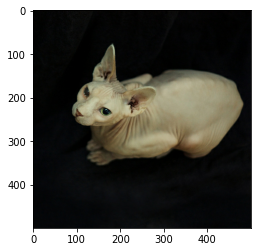

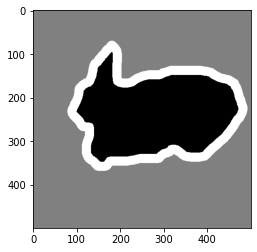

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

#for data in dataset[].take(1):
for data in dataset['train']:
  print('file_name', data['file_name'])
  print('image', data['image'].shape)
  plt.figure()
  plt.imshow(data['image'])
  print('label', data['label'], class_names[data['label']])
  print('segmentation_mask', data['segmentation_mask'].shape)
  plt.figure()
  plt.imshow(np.resize(data['segmentation_mask'], (500, 500)), cmap='gray')
  print('species', data['species'])
  break

## 14.2.3 U-Net

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png" width=800 />


* 수정된 U-Net
* 인코더(다운샘플러) - MobileNetV2  --> ResNet50으로 변경
* 디코더(업샘플러) - pix2pix의 upsample 블록

In [ ]:
# For VGG16 this is the input size
width, height, channel = 224, 224, 3
input_shape=(width, height, channel)

inputs = tf.keras.Input(shape=input_shape)
encoder = tf.keras.applications.vgg16.VGG16(
    include_top=False, weights='imagenet', input_tensor=inputs)

# Use the activations of these layers
layer_names = [
    'block1_pool',  # 112, 112, 64
    'block2_pool',  # 56, 56, 128
    'block3_pool',  # 28, 28, 256
    'block4_pool',  # 14, 14, 512
    'block5_pool',  # 7, 7, 512
]
encoder_outputs = [encoder.get_layer(name).output for name in layer_names]

#features=encoder(inputs)
encoder=tf.keras.Model(inputs=inputs, outputs=encoder_outputs)
encoder.trainable = False
encoder.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:

#encoder_output=encoder.output # 224 x 224 x 3 -> 7 x 7 x 512
#encoder_output.shape
for idx, output in enumerate(encoder_outputs):
  print('output {}, {}'.format(idx+1, output.shape))
#pool = tf.keras.layers.GlobalAveragePooling2D()(features_output)
#output_layer=tf.keras.layers.Dense(10,activation='softmax')(pool)
#model=tf.keras.models.Model(inputs=input_layer,outputs=output_layer)
#model.summary()

output 1, (None, 112, 112, 64)
output 2, (None, 56, 56, 128)
output 3, (None, 28, 28, 256)
output 4, (None, 14, 14, 512)
output 5, (None, 7, 7, 512)


In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

  Preparing metadata (setup.py) ... done
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. Discussion can be found at https://github.com/pypa/pip/issues/8368


In [ ]:
decoder = [
    pix2pix.upsample(512, 3),  # 7x7 -> 14x14
    pix2pix.upsample(256, 3),  # 14x14 -> 28x28
    pix2pix.upsample(128, 3),  # 28x28 -> 56x56
    pix2pix.upsample(64, 3),   # 112x112 -> 224x224
]

In [ ]:
def unet_model(inputs, output_channels):

  # Downsampling through the model
  skips = encoder(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(decoder, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2, padding='same')  #112x112 -> 224x224

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

model=unet_model(inputs, 3)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_6 (Functional)           [(None, 112, 112, 6  14714688    ['input_13[0][0]']               
                                4),                                                               
                                 (None, 56, 56, 128                                               
                                ),                                                                
                                 (None, 28, 28, 256                                         

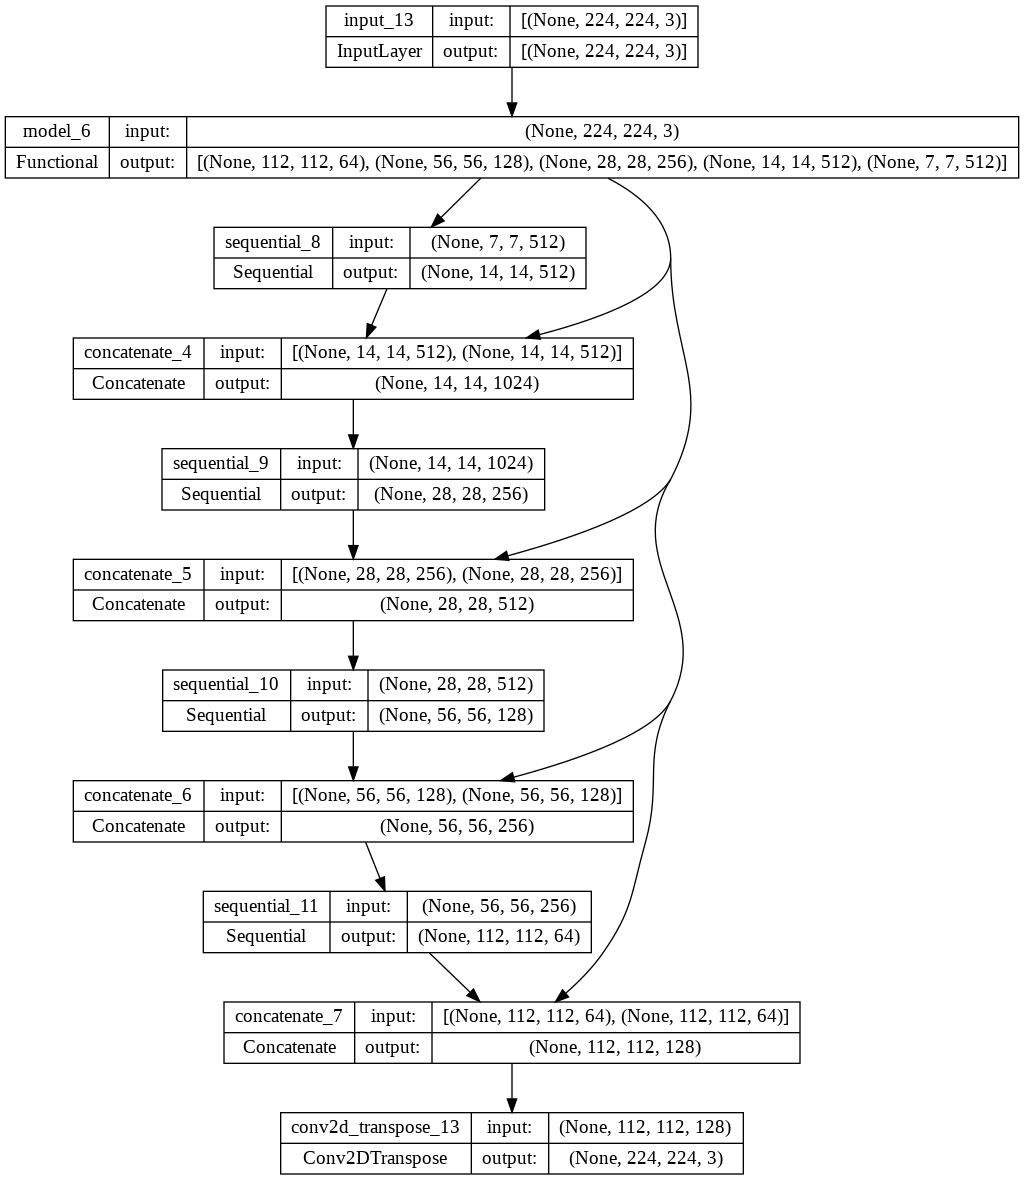

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## 14.2.4 Preparing dataset



In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (width, height))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (width, height),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )
  # input_image = datapoint['image']
  # input_mask = datapoint['segmentation_mask']
  # print(input_image.shape, input_mask.shape)
  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    #.map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

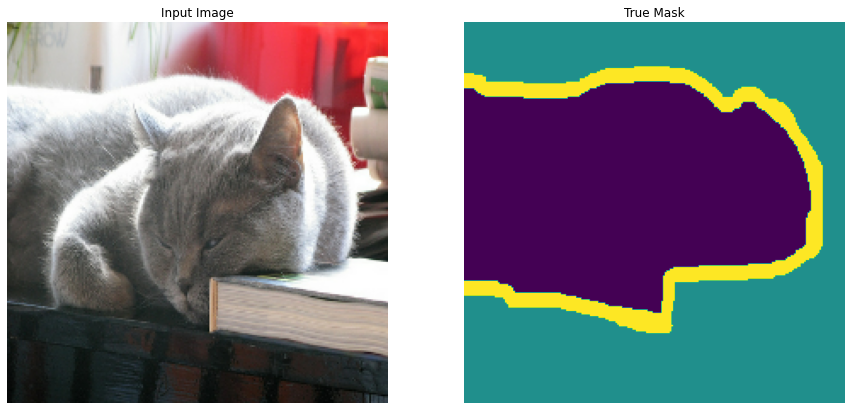

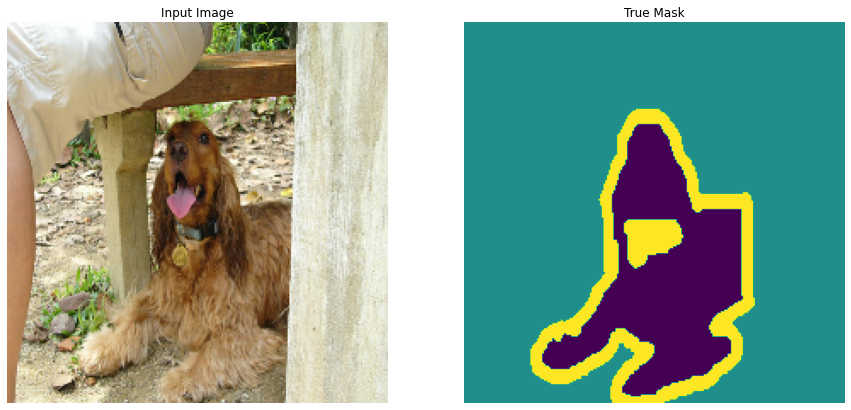

In [ ]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## 14.2.5 Training

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])  

1/1 [==============================] - 1s 1s/step


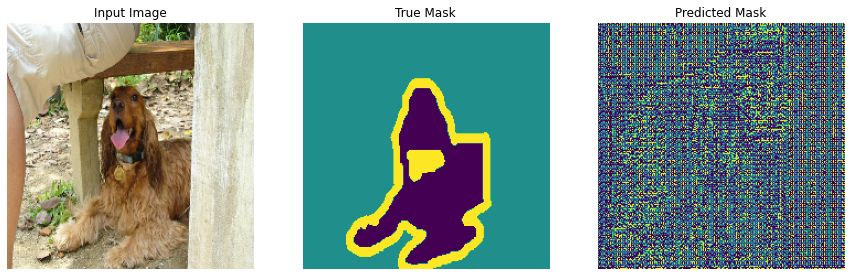

In [ ]:
show_predictions()

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 10
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(test_batches, 3)